<a href="https://colab.research.google.com/github/dscoool/machinelearning11/blob/main/10_koreapic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10. 김홍도와 신윤복의 화풍 분류

*   이미지 학습 알고리즘 중 CNN에 대해 이해한다.
*   이미지 데이터 수집 및 전처리 방법을 이해한다.
*   기초 수준의 이미지 학습 인공지능 모델을 제작한다.

### CNN이란?


*   일반적인 딥러닝에서 이미지 처리시 문제점을 보완함. 이미지 특징을 유지한채 학습하는 것이 큰 특징.

*   **Convolution(컨볼루션)** : 이미지의 각 특징을 부분적으로 가져오는 과정. 이미지 크기보다 작은 필터를 사용하여, 특징을 판별한다.
*   **Pooling(풀링):** Convolution과정에서 나오는 많은 수의 결과 값을 축소해 주는 과정. 특징을 뽑아내고 나머지 값은 버린다.
*   Convolution(컨볼루션)과정과 Pooling(풀링)을 반복하여, 최종적으로 도출된 2차원 데이터를 1차원으로 변형하고(Flatten) 이후 네트워크를 통해서 결과를 출력한다



#1. 구글 드라이브 연동
이미지 폴더(pic)를 구글 드라이브에 업로드 한 후, 코랩에 연동한다.

In [1]:
import os
import glob
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


#2. 경로 지정 및 파일 이름 저장

  

> * 초기경로 : /gdrive/Mydrive
*   신윤복 학습데이터 : 초기경로 + /Shin
*   김홍도 학습데이터 : 초기경로 + /Kim

---
*   파일 이름 리스트 저장 : Os 모듈의 listdir() 함수 이용

*   경로 지정 작업과 파일 이름 리스트 저장 작업을 완료하면 파일 이름과 갯갯수 확인가능

In [3]:
path = "/gdrive/MyDrive/pic"

# 신윤복/김흥도 데이터셋 경로 지정
train_shin_dir = path + '/Shin'
train_kim_dir = path + '/Kim'

# 신윤복 파일 이름 리스트
train_shin_names = os.listdir(train_shin_dir)
print(train_shin_names[:10])

# 김흥도 파일 이름 리스트
train_kim_names = os.listdir(train_kim_dir)
print(train_kim_names[:10])

# 신윤복/김흥도 총 이미지 파일 개수
print('total training shin images:', len(os.listdir(train_shin_dir)))
print('total training kim images:', len(os.listdir(train_kim_dir)))

['신윤복12.jpg', '신윤복10.jpg', '신윤복14.jpg', '신윤복15.jpg', '신윤복13.jpg', '신윤복11.jpg', '신윤복1.jpg', '신윤복6.jpg', '신윤복28.jpg', '신윤복26.jpg']
['김홍도10.jpg', '김홍도1.jpg', '김홍도11.jpg', '김홍도4.jpg', '김홍도3.jpg', '김홍도7.jpg', '김홍도23.jpg', '김홍도16.jpg', '김홍도15.jpg', '김홍도8.jpg']
total training shin images: 30
total training kim images: 26


이미지 파일이 담긴 파일을 glob(  )함수로 리스트로 묶는다.

In [4]:
train_shin = glob.glob(path + '/Shin'+'/*')
train_kim = glob.glob(path + '/Kim'+'/*')

이미지 처리를 위한 모듈인 cv2와 imshow를 호출하고 아래와 같이 이미지 파일을 읽는 함수를 정의한다.

*   cvtColor(  ) 함수 :  파랑, 초록, 빨강(BGR) 순 -> 빨강, 초록, 파랑(RGB)순으로 변환

In [5]:
!pip install opencv-python
!pip install tensorflow

In [6]:
import cv2
from matplotlib.pyplot import imshow

#이미지를 읽는 함수
def read_img(file_path):
  img_arr = cv2.imread(file_path)
  return cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB) #BGR을 RGB로

이미지를 불러와 시각화하기


*   random.sample : 임의의 이미지 불러오기
*   행 (column)과 열(row)은 2×2
*   plt.subplots(  ) 함수로 표시할 이미지 개수와 사이즈를 설정
*  imshow(  ) 함수로 이미지 나타내기

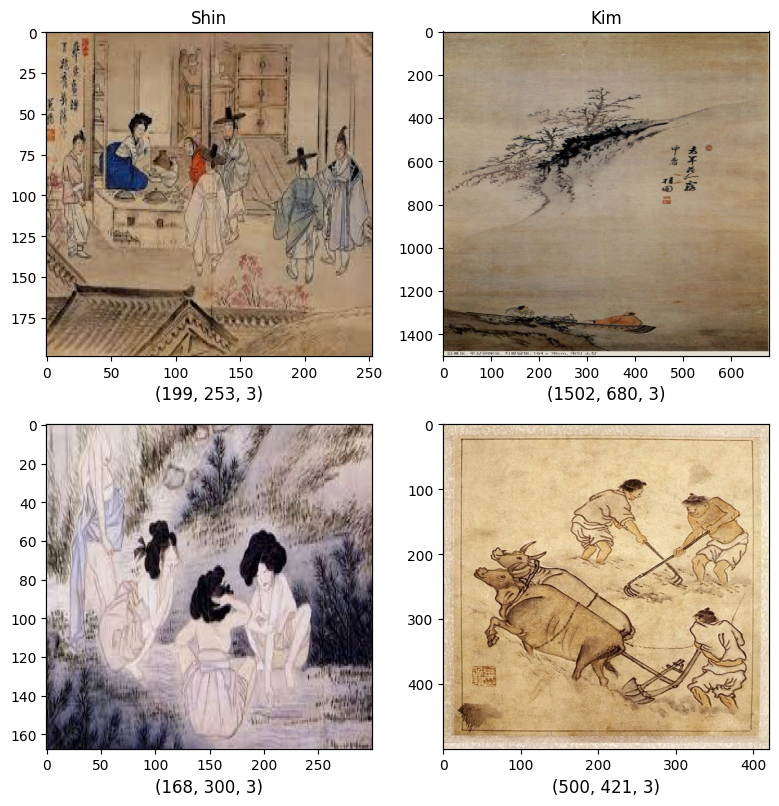

In [7]:
#이미지 확인하기 - 2개씩

import random
img_arrs = []
img_num = range(0, 26)

for i in random.sample(img_num, 2):
  img_arrs.append(read_img(train_shin[i]))
  img_arrs.append(read_img(train_kim[i]))

rows = 2
colums = 2

fig, axes = plt.subplots(nrows=rows, ncols=colums , figsize = (colums*4, rows*4))

for num in range(1, rows*colums+1):
  fig.add_subplot(rows, colums, num)
  idx = num - 1
  plt.imshow(img_arrs[idx], aspect='auto')
  plt.xlabel(f'{img_arrs[idx].shape}', fontsize = 12)

fig.tight_layout()

cols = ['Shin', 'Kim'] #제목

for folder_idx, ax in enumerate(axes[0]):
  ax.set_title(cols[folder_idx])

for idx, ax in enumerate(axes.flat):
  ax.set_xticks([])
  ax.set_yticks([])

# 3. 이미지 데이터 전처리하기



이미지 모듈을 호출하고 이를 이용하여 이미지 전처리를 해 보자

인공지능 학습을 위해서는 동일한 크기의 이미지 데이터로 변환해야 한다

*   img.resize(  ) 함수로 크기를 변환 (예제에서는 300×300)
*   변환된 이미지를 다른 폴더에 저장 (예제에서는 re_shin, re_kim)

In [8]:
from PIL import Image

In [9]:
for i in train_shin_names:
  img = Image.open(train_shin_dir + '/' + i)

  img_resize = img.resize((300, 300))
  img_resize.save('/gdrive/MyDrive/pic/train/re_shin/'+ i)

In [10]:
for i in train_kim_names:
  img = Image.open(train_kim_dir + '/' + i)

  img_resize = img.resize((300, 300))
  img_resize.save('/gdrive/MyDrive/pic/train/re_kim/'+ i)

# 4. CNN 모델 생성하기

텐서플로 모듈을 호출하고 Convolution과 Pooling 과정을 반복하여 CNN 모델을 생성한다.


*   Conv2D : Convolution을 해 주는 함수
*   MaxPool2D: Pooling을 해 주는 함수 (최대 풀링)

---


*   Conv2D의 첫 번째 인자는 필터 값을 의미
*   두 번째 인자(3, 3)는 필터 사이즈
*   첫 번째 Convolution 과정에는 이미지 데이터 정보(300, 300 , 3)를 inputshape으로 전달항목 추가
---
*   최댓값으로 Pooling을 진행
*   매개 변수(2,2)로 필터의 크기를 설정
---
*   Flatten(  ) 함수를 통해 2차원 데이터를 1차원 데이터로 변환
*   Dense(  ) 과정을 통해 딥러닝으로 학습


In [11]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # The first convolution
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    # 512 Neuron (Hidden layer)
    tf.keras.layers.Dense(512, activation='relu'),
    # 1 Output neuron
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 33, 33, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
import sys
print(sys.version)

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


# 5. CNN 모델 컴파일


optimizer(최적화 기법)로 **RMSprop**를 사용

*   경사 하강 시 스텝 사이즈를 조절하는 특징을 가짐
*   장점 : 학습률을 쉽게 줄일 수 있고 이미지학습에서 평균적으로 오차가 더 작다.




*   데이터 설정 목적을 위해 ImageDataGenerator를 사용한다
*   RGB 값을 255로 나누어 0~1사이의 값으로 정규화하는 과정을 진행(Rescale)
*   경로 설정과 이미지 크기, batch_size, 분류 모드를 설정




In [18]:
train_generator = train_datagen.flow_from_directory(
        path + '/train',
        target_size=(300, 300),
        batch_size=7,
        class_mode='binary',
        classes=['re_shin', 're_kim']  # Replace with actual class names
    )

Found 56 images belonging to 2 classes.


# 6. CNN 모델 학습
모델 fit을 설정하여 학습을 진행한다.

In [19]:
history = model.fit(train_generator, steps_per_epoch=8, epochs=15, verbose=1)
# train_generator : 학습 데이터
# steps_per_epoch : 학습에서 사용할 batch 개수
# - 데이터의 개수(56)를 bach_size(7)로 나눈 값(8)을 입력
# Epochs : 학습 횟수 설정
# verbose = 1 : 연산 세부정보가 모두 표시되도록 설정

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5122 - loss: 1.0369
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5181 - loss: 0.6918
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4720 - loss: 0.6966
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5547 - loss: 0.6868
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5840 - loss: 0.7347
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4108 - loss: 0.7446
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6806 - loss: 0.7074
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7210 - loss: 0.6449
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8333 - loss: 0.8648
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8198 - loss: 0.4560
Epoch 11/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8358 - loss: 0.4534
Epoch 12/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7473 - loss: 0.4709
Epoch 13/15


# 7. CNN 모델 테스트

pic 폴더에 있는 ‘공원춘효도.jpg’ 파일을 다운로드

코랩 업로드 모듈을 활용하여 ‘공원춘효도’ 이미지 파일을 업로드 한다.


In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [21]:
from google.colab import files

uploaded=files.upload()

Saving 공원춘효도.jpg to 공원춘효도.jpg


In [22]:
img1 = Image.open('/content/공원춘효도.jpg')

이미지를 읽고 300×300으로 크기로 변환한다.

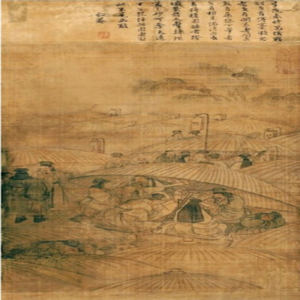

In [23]:
img_resize1 = img1.resize((300, 300))
img_resize1


*   img_to_array(  ) 함수로 정렬 및 넘파이(numpy) 배열에 저장
*   expand_dims(  ) 함수로 결과를 담을 공간(차원) 추가
*   vstack(  )로 추가된 차원 적재


In [25]:
test_img1 =image.img_to_array(img_resize1)

In [26]:
test_img1 = np.expand_dims(test_img1, axis=0)
images1 = np.vstack([test_img1])

In [ ]:
images1

 이미지 전처리를 마친 <공원춘효도>를 model.predict(  )에 넣어 테스트한다.


In [27]:
classes = model.predict(images1, batch_size=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


In [28]:
print(classes[0])

if classes[0]>0:
  print("Painting by Shin Yun-bok.")
else:
  print("Painting by Kim Hong-do.")

[1.]
Painting by Shin Yun-bok.


# 더 알아보기
<월하정인> 그림을 크기 변환 및 전처리 하여 테스트를 진행한다

In [29]:
uploaded2=files.upload()

Saving 신윤복5.jpg to 신윤복5.jpg


In [32]:
img2 = Image.open('/gdrive/MyDrive/pic/월하정인.jpg')

In [33]:
img_resize2 = img2.resize((300, 300))

In [34]:
test_img2 =image.img_to_array(img_resize2)

In [35]:
test_img2 = np.expand_dims(test_img2, axis=0)
images2 = np.vstack([test_img2])

In [36]:
classes = model.predict(images2, batch_size=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


테스트 결과, **신윤복 작품**으로 판별하는 것을 확인 할 수 있다

[0.]
Painting by Kim Hong-do.


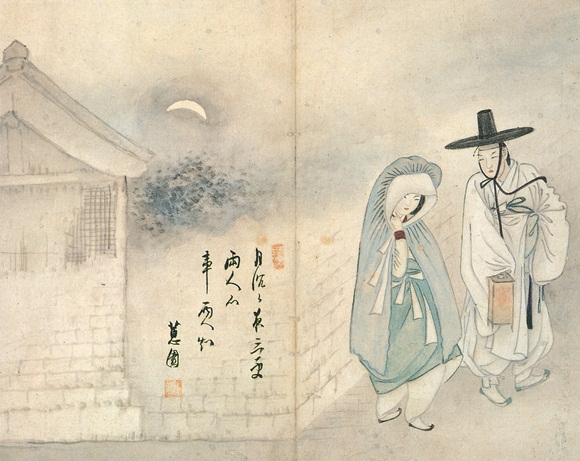

In [37]:
print(classes[0])

if classes[0]>0:
  print("Painting by Shin Yun-bok.")
else:
  print("Painting by Kim Hong-do.")
img2

월하정인의 그림 속의 글을 보면 달의 모양이 이상하다는 것을 알 수 있다.
- 그림에서는 초승달이 뜨는 초저녁으로 보이지만 글에서는 한밤 중(11시~1시)으로 적혀 있다.

정답은 초승달이 아니라 **개기 월식의 부분**을 그린 것이다!

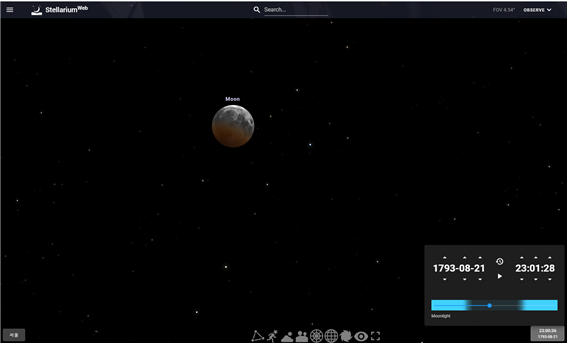